In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [8]:
bin_margins = np.linspace(0, 1, 6)[:-1]
batch_size = 32
epochs = 60

In [9]:
# import dataset (comes with colab!)
data = np.loadtxt(open("../../datasets/mnist_train_small.csv", "rb"), delimiter=",")

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

In [10]:
data_normalized = data / np.max(data)

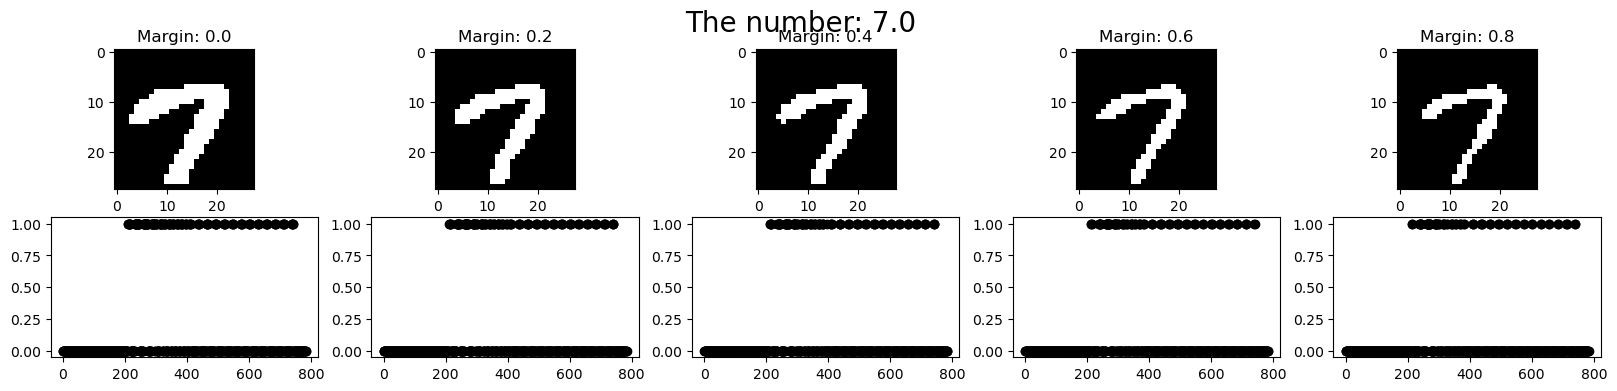

In [20]:
random_image = np.random.randint(0, high=data.shape[0])

fig, axs = plt.subplots(2, 5, figsize=(20, 4))

for col, margin in enumerate(bin_margins):
    data_binarized = np.where(data_normalized > margin, 1, 0)
    for row in range(2):
        ax = axs[row, col]
        if row == 0:
            ax.imshow(np.reshape(data_binarized[random_image, :], (28, 28)), cmap='gray')
            ax.set_title(f"Margin: {round(margin, 1)}")
        elif row == 1:
            ax.plot(data_binarized[random_image, :].squeeze(), 'ko')

plt.suptitle(f"The number: {labels[random_image]}", fontsize=20)

plt.show()

In [12]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(784, 64)

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 32)

        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.log_softmax(self.output(x), dim=1)

In [13]:
def create_data(margin):
    data_binarized = np.where(data_normalized > margin, 1, 0)

    data_tensor = torch.tensor(data_binarized).float()
    labels_tensor = torch.tensor(labels).long()

    train_data, test_data, train_labels, test_labels = train_test_split(
        data_tensor,
        labels_tensor,
        test_size=.1,
        shuffle=True
    )

    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader

In [14]:
def create_model():
    model = MnistModel()
    loss_func = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)

    return model, loss_func, optimizer

In [15]:
def train_model(margin):
    model, loss_func, optimizer = create_model()
    train_loader, test_loader = create_data(margin)

    model = model.to(device)
    loss_func = loss_func.to(device)

    losses = torch.zeros(epochs).to(device)
    train_acc = torch.zeros(epochs).to(device)
    test_acc = torch.zeros(epochs).to(device)

    for epoch in range(epochs):
        model.train()

        batches_quantity = len(train_loader)
        batch_acc = torch.zeros(batches_quantity).to(device)
        batch_losses = torch.zeros(batches_quantity).to(device)

        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            loss = loss_func(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses[batch_idx] = loss.item()

            matches = torch.argmax(preds, dim=1) == y
            matches_float = matches.float()
            accuracy = 100 * torch.mean(matches_float)
            batch_acc[batch_idx] = accuracy

        train_acc[epoch] = torch.mean(batch_acc)
        losses[epoch] = torch.mean(batch_losses)

        model.eval()
        X, y = next(iter(test_loader))
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            preds = model(X)

        matches = torch.argmax(preds, dim=1) == y
        matches_float = matches.float()
        accuracy = 100 * torch.mean(matches_float)
        test_acc[epoch] = accuracy

    return train_acc, test_acc, losses, model


In [16]:
def run_the_experiment():
    train_acc = torch.zeros(epochs, len(bin_margins)).to(device)
    test_acc = torch.zeros(epochs, len(bin_margins)).to(device)

    for idx, margin in enumerate(bin_margins):
        margin_train_acc, margin_test_acc, losses, model = train_model(margin)
        train_acc[:, idx] = margin_train_acc
        test_acc[:, idx] = margin_test_acc

    return train_acc, test_acc

In [17]:
train_acc, test_acc = run_the_experiment()

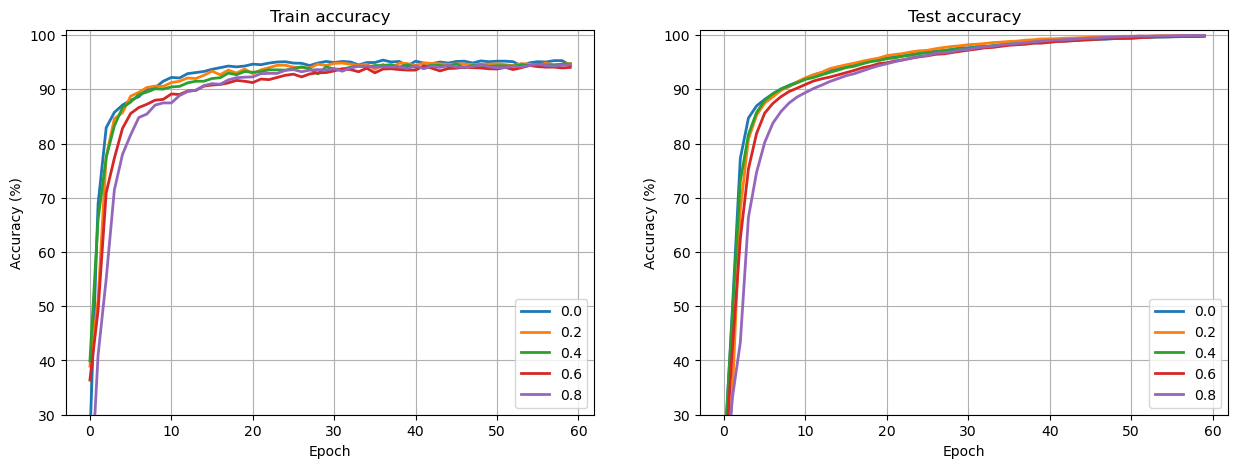

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_acc.to("cpu").numpy(), linewidth=2)
ax[0].set_title("Train accuracy")
ax[1].plot(test_acc.to("cpu").numpy(), linewidth=2)
ax[1].set_title("Test accuracy")

leg_labels = [np.round(i, 2) for i in bin_margins]

for i in range(2):
    ax[i].legend(leg_labels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([30, 101])
    ax[i].grid()

plt.show()